In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json


COLOUR_PALETTE = {
    # Top 5 Subfields (Higher Relevance)
    "Artificial Intelligence": "#D32F2F",
    "Computer Vision and Pattern Recognition": "#1976D2",
    "Information Systems": "#2E7D32",
    "Computational Theory and Mathematics": "#6A1B9A",
    "Computer Networks and Communications": "#FF6F00",
    
    # Additional Subfields
    "Computer Science Applications": "#00838F",
    "Software": "#0ad600",
    "Signal Processing": "#2CCFDB",
    "Human-Computer Interaction": "#CE59D4",
    "Hardware and Architecture": "#455A64",
    "Computer Graphics and Computer-Aided Design": "#D6914B"
}

MARKERS = {
    # Top 5 Subfields (Higher Relevance)
    "Artificial Intelligence": "P",
    "Computer Vision and Pattern Recognition": "o",
    "Information Systems": "X",
    "Computational Theory and Mathematics": "s",
    "Computer Networks and Communications": "v",

    # Additional Subfields
    "Computer Science Applications": "D",
    "Software": "d",
    "Signal Processing": "p",
    "Human-Computer Interaction": "*",
    "Hardware and Architecture": "<",
    "Computer Graphics and Computer-Aided Design": ">"
}


country_ids = {
    "BR": "Brazil",
    "US": "United States",
    "CN": "China",
    "ID": "Indonesia",
}


def plot_publication_percentages_by_country(df):
    """
    Reads the aggregated publication counts CSV and creates a line plot for each country.
    For each country, it computes the percentage of publications per subfield (i.e.,
    number of publications of a subfield divided by the total publications for that year)
    for the top 5 subfields, and plots these percentages over the years 2019 to 2024.
    A common legend is displayed at the bottom.
    """
    # Load the CSV file and ensure publication_year is integer
    df["publication_year"] = df["publication_year"].astype(int)

    # Get unique country codes
    countries = df["country_code"].unique()

    # Setup seaborn theme for better visuals
    sns.set_theme(style="whitegrid", context="paper", font_scale=2.2)

    # Create a subplot grid: here we assume 4 countries and use a 2x2 grid (adjust as needed)
    n_countries = len(countries)
    n_rows = (n_countries + 1) // 2
    fig, axes = plt.subplots(
        n_rows, 2, figsize=(16, 5 * n_rows), sharex=True, sharey=True
    )
    axes = axes.flatten()

    # Dictionary to collect legend entries across subplots
    legend_entries = {}

    for i, country in enumerate(countries):
        ax = axes[i]
        ax.grid(True, linestyle='--', alpha=0.7)
        # Filter data for the current country and work on a copy
        df_country = df[df["country_code"] == country].copy()

        # Compute the total publications per year for this country
        total_per_year = (
            df_country.groupby("publication_year")["count"]
            .sum()
            .reset_index(name="total")
        )
        df_country = df_country.merge(total_per_year, on="publication_year")

        # Calculate the percentage of publications for each subfield per year
        df_country["percentage"] = (df_country["count"] / df_country["total"]) * 100

        # Determine top 5 subfields (by total count over the period for that country)
        subfield_totals = (
            df_country.groupby("subfield_display_name")["count"].sum().reset_index()
        )
        top5 = subfield_totals.nlargest(5, "count")["subfield_display_name"].tolist()

        # Filter to only include rows for these top subfields
        df_top = df_country[df_country["subfield_display_name"].isin(top5)]

        # Create the line plot for percentages by publication year for the top subfields
        lineplot = sns.lineplot(
            data=df_top,
            x="publication_year",
            y="percentage",
            hue="subfield_display_name",
            palette=COLOUR_PALETTE,  # <--- Added palette mapping
            style="subfield_display_name",
            markers=MARKERS,
            markersize=8,
            dashes=False,
            ax=ax,
            linewidth=1.5,
        )
        ax.set_title(f"Country: {country_ids[country]}")
        ax.set_xlabel("Publication Year")
        ax.set_ylabel("Percentage (%)")

        # Remove individual legends from subplots
        ax.get_legend().remove()

        # Collect legend handles and labels from the first subplot (assuming consistency across plots)
        if i == 0:
            handles, labels = lineplot.get_legend_handles_labels()
            for h, l in zip(handles, labels):
                legend_entries[l] = h

    # Hide any unused subplots if number of countries is less than the grid size
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    # Create a common legend from the collected legend entries
    common_labels = sorted(legend_entries.keys())
    common_handles = [legend_entries[label] for label in common_labels]
    fig.legend(
        common_handles,
        common_labels,
        loc="lower center",
        ncol=3,
        bbox_to_anchor=(0.5, -0.02),
    )


    fig.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig(
        "../docs/publication_percentages_by_country.pdf",
        format="pdf",
        bbox_inches="tight",
    )

    return fig


def compute_unique_author_counts(df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes the number of unique authors per subfield per publication year.
    
    Each publication's 'authorships' JSON is parsed to extract author IDs and
    the 'subfield' JSON is parsed to get the display name.
    
    Returns:
      A DataFrame with columns:
        - 'subfield'             : the subfield display name.
        - 'publication_year'     : the publication year.
        - 'unique_authors_count' : the count of unique authors for that subfield/year.
        
      Only data for the top 5 subfields (by cumulative unique authors) are returned.
    """
    # Dictionaries to store unique author IDs per (subfield, year) and overall per subfield.
    subfield_year_authors = {}
    overall_subfield_authors = {}

    for _, row in df.iterrows():
        year = row["publication_year"]
        # Parse the subfield JSON string to get its display name.
        subfield = json.loads(row["subfield"]).get("display_name")
        # Parse the authorships JSON string to get a list of authors and extract their IDs.
        authors_list = json.loads(row["authorships"])
        author_ids = {author["id"] for author in authors_list}

        key = (subfield, year)
        subfield_year_authors.setdefault(key, set()).update(author_ids)
        overall_subfield_authors.setdefault(subfield, set()).update(author_ids)

    # Build a DataFrame for per-year counts.
    records = [
        {"subfield": subfield, "publication_year": year, "unique_authors_count": len(authors)}
        for (subfield, year), authors in subfield_year_authors.items()
    ]
    counts_df = pd.DataFrame(records)

    # Compute cumulative counts per subfield.
    cumulative_records = [
        {"subfield": subfield, "cumulative_authors": len(authors)}
        for subfield, authors in overall_subfield_authors.items()
    ]
    cumulative_df = pd.DataFrame(cumulative_records)

    # Identify the top 5 subfields by cumulative unique authors.
    top_subfields = cumulative_df.sort_values("cumulative_authors", ascending=False).head(5)["subfield"].tolist()
    counts_df = counts_df[counts_df["subfield"].isin(top_subfields)]

    return counts_df


def lineplot_authors_per_year(counts_df: pd.DataFrame) -> plt.Figure:
    """
    Creates a line plot showing the number of unique authors per subfield per year.
    
    Parameters:
      counts_df : DataFrame with columns 'subfield', 'publication_year', and 'unique_authors_count'
                 (typically produced by compute_unique_author_counts).
    
    Returns:
      A matplotlib Figure object.
    """
    # Set Seaborn style to a research paper aesthetic.
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
    
    # Create the figure and axis.
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Generate the line plot.
    sns.lineplot(data=counts_df, x="publication_year", y="unique_authors_count",
                 hue="subfield", marker="o", ax=ax)
    
    ax.set_xlabel("Publication Year")
    ax.set_ylabel("Unique Authors Count")
    ax.set_title("Unique Authors per Publication Year by Top 5 Subfields")
    
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    
    return fig

In [2]:
countries_subfields_df = pd.read_csv(
    "../data/csv/openalex/countries_subfields.csv"
)

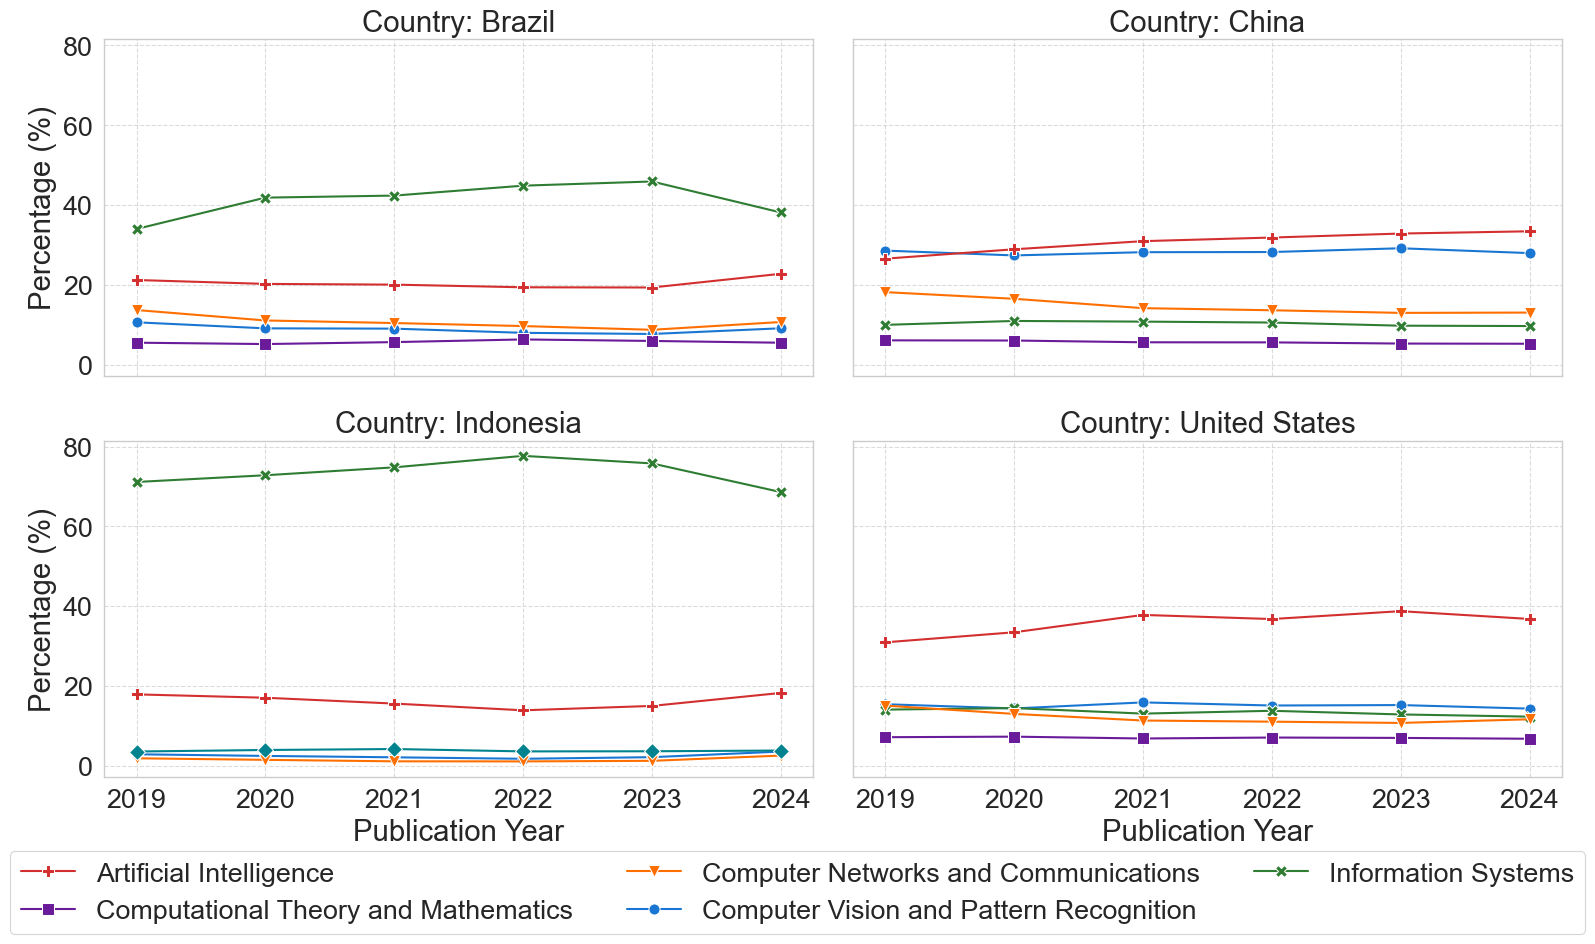

In [3]:
plot_publication_percentages_by_country(countries_subfields_df)
plt.show()

In [4]:
br_publications = pd.read_csv('../data/csv/openalex/br_publications.csv')

In [5]:
authors_subfields_df = compute_unique_author_counts(br_publications)

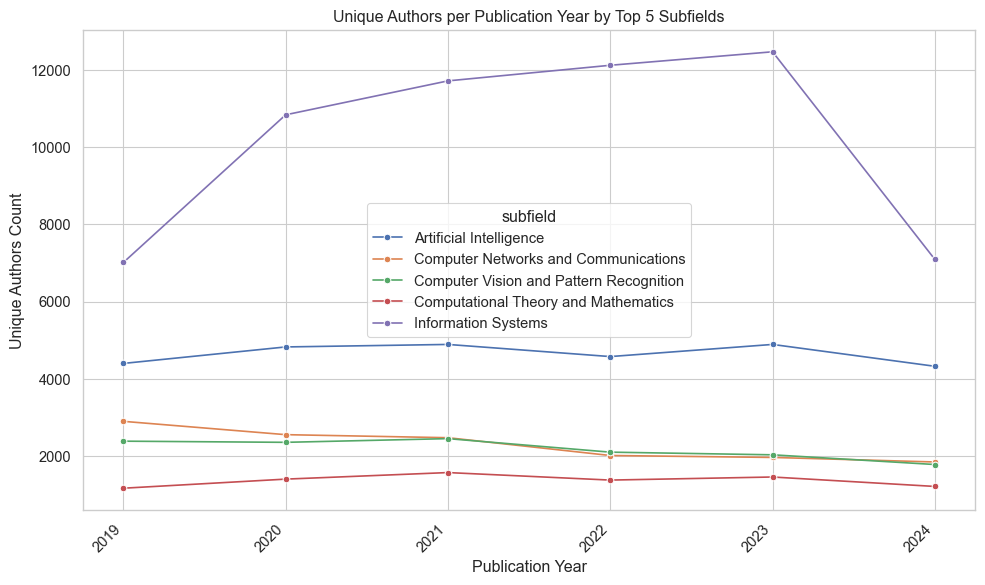

In [6]:
lineplot_authors_per_year(authors_subfields_df)
plt.show()

In [7]:
# plot_avg_citations_by_country(countries_subfields_df)
# plt.show()

In [8]:
# all_countries_df = pd.read_csv("../data/csv/elsevier_counts/all_countries_cs.csv")
# all_countries_df

In [9]:
# plot_publication_percentages_by_country(all_countries_df)
# plt.show()

In [11]:
# print colour palette keys and values, sorted by key
for key, value in sorted(COLOUR_PALETTE.items()):
    print(key, value)

Artificial Intelligence #D32F2F
Computational Theory and Mathematics #6A1B9A
Computer Graphics and Computer-Aided Design #D6914B
Computer Networks and Communications #FF6F00
Computer Science Applications #00838F
Computer Vision and Pattern Recognition #1976D2
Hardware and Architecture #455A64
Human-Computer Interaction #CE59D4
Information Systems #2E7D32
Signal Processing #2CCFDB
Software #0ad600
